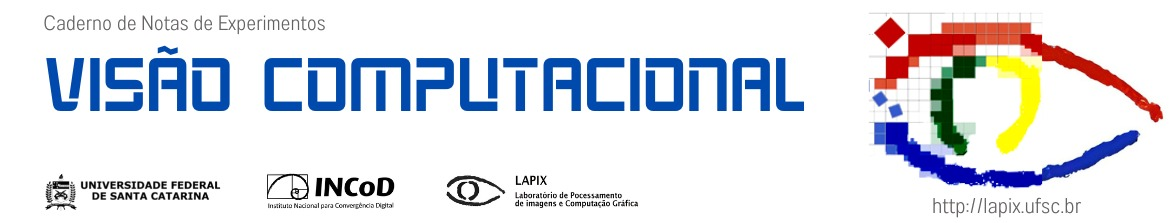






<a href="https://colab.research.google.com/github/awangenh/vision/blob/master/jupyter/02.1.Dom%C3%ADnios%20do%20Valor%20e%20Espa%C3%A7o%20-%20Detector%20de%20Carros.ipynb"><img align="left"  src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open in Colab" title="Open and Execute in Google Colaboratory"></a>&nbsp; &nbsp;<a href=""><img align="left" src="http://www.lapix.ufsc.br/wp-content/uploads/2019/04/License-CC-BY-ND-4.0-orange.png" alt="Creative Commons 4.0 License" title="Creative Commons 4.0 License"></a>&nbsp; &nbsp; <a href=""><img align="left" src="http://www.lapix.ufsc.br/wp-content/uploads/2019/04/Jupyter-Notebook-v.1.0-blue.png" alt="Jupyter Version" title="Jupyter Version"></a>&nbsp; &nbsp;<a href=""><img align="left"  src="https://img.shields.io/badge/python-3.10-green" alt="Python Version" title="Python Version"></a>

# 2.1. Sistema de Detecção de Trens

Neste primeiro caderno de notas do nosso curso de Visão Computacional você vai desenvolver as duas primeiras etapas de um sistema de detecção de veículos que "furam o sinal" em um semáforo. O sistema deve soar um alarme sempre que um veículo é flagrado em uma "zona proibida" em um semáforo quando ele estiver fechado.

Para isso você vai aprender a aplicar uma combinação de métodos nos domínios do valor e do espaço. No momento você ainda não aprendeu nenhum método no domínio do espaço, viu apenas o domínio do valor, mas isso não é importante alguns métodos de morfologia matemática de forma intuitiva aqui e depois, na aula de domínio do valor, nós vamos explicar os princípios matemáticos por trás desses métodos. Assim você poderá assistir à aula teórica já com uma compreensão intuitiva de o que pode ser feito com esses métodos.

Vamos ver o que esta, que parece ser uma tarefa complexa na qual você necessita identificar um veículo em uma situação "proibida", na verdade pode ser desenvolvida com métodos muito simples e que podem, se necessário, ser embarcados em uma câmara de vigilância. As imagens exemplo que vamos processar aqui foram capturadas com uma câmera digital Sony bastante simples em um semáforo próximo à UFSC em 1998: mesmo com estas imagens de relativa má qualidade, pelos padrões de fotografia digital de hoje, é possível realizar essa tarefa sem problemas.

O cadernos de notas é dividido em duas partes: 
* na primeira parte vamos usar apenas métodos no Domínio do Valor e, a final, discutir quais as falhas deste enfoque e porque o resultado é insatisfatório;
* na segunda parte, depois de você ter visto Operadores Morfológicos, vamos introduzir estes métodos na sua pipeline de processamento e você vai aprender como, com estes filtros simples, é possível "limpar" a imagem de forma a você ter um resultado muito melhor. 


### Info on Jupyter Notebooks

Look here:
 * [LAPIX::Jupyter Notebooks na UFSC (Seminário para Professores do INE2019.1)](http://www.lapix.ufsc.br/jupyter-notebooks-na-ufsc/)
 * [LAPIX::Como Importar Jupyter Notebooks de GitHub para Google Colab?](http://www.lapix.ufsc.br/ensino/como-importar-jupyter-notebooks-de-github-para-google-colab/)

# 2.1.1. Inicializações

## Checando onde você está rodando este bloco de notas...

# 2.1.2. Instalações comuns a todos os exercícios

If you are at your computer at home and have installed Anaconda, what needs to be additionally installed?

In [48]:
# Install latest OpenCV with Python Interface using the Python Install Program
#!pip3 install opencv-python

### Common Initializations

In [49]:
#!pip install matplotlib
%reload_ext autoreload
%autoreload 2

# Make matplotlib draw graphics directly onto the notebook and not in a window
%matplotlib inline

# 2.1.3. Exemplo no Domíno do Valor: Detetor de Carros

## 2.1.3.1. Uma Solução Ingênua

### Initialize and load first image: via com trens

In [50]:
from PIL import Image 
Image.open("../data/pico_manha.gif").convert('RGB').save("../data/pico_manha.jpg")

In [1]:
#!pip install ipywidgets
import cv2
import matplotlib
import numpy as np
from matplotlib import pyplot as plt
# Import interaction widgets and functions
from ipywidgets import interact, interactive, interact_manual

# Load the image in color (OpenCV standard = BGR)
orig = cv2.imread("../data/pico_manha.jpg", cv2.IMREAD_COLOR)
# Convert to RGB
orig = cv2.cvtColor(orig, cv2.COLOR_BGR2RGB)

# Load the image in grayscale

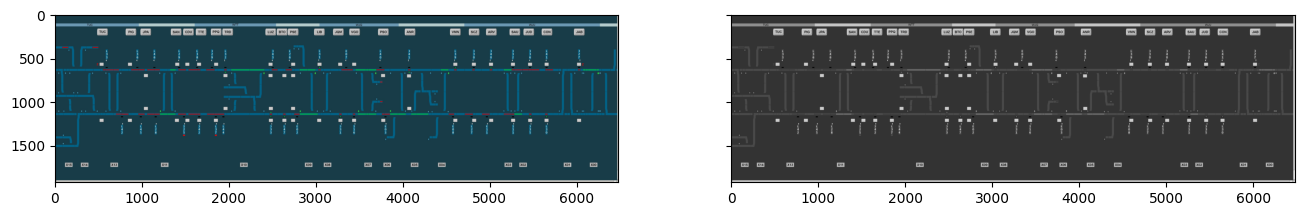

In [2]:
gray = cv2.imread("../data/pico_manha.jpg", cv2.IMREAD_GRAYSCALE)

fig, axes = plt.subplots(1, 2, figsize=(16, 12), sharex=True, sharey=True)
ax = axes.ravel()
ax[0].imshow(orig)
ax[1].imshow(gray, 'gray')

### Load a Reference Image

The simplest strategy, used in CCTV cameras, is to compare frames to a reference image. This image does not need to be static, it can be automatically updated always when nothing happens for a long time...

In [ ]:
Image.open("../data/referencia.gif").convert('RGB').save("../data/referencia.jpg")

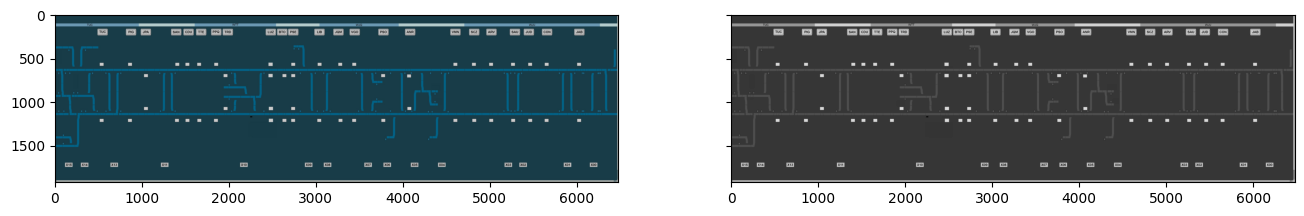

In [4]:
# Load the image in color (OpenCV standard = BGR)
ref_orig = cv2.imread("../data/referencia.jpg", cv2.IMREAD_COLOR)
# Convert to RGB
ref_orig = cv2.cvtColor(ref_orig, cv2.COLOR_BGR2RGB)

# Load the image in grayscale
ref_gray = cv2.imread("../data/referencia.jpg", cv2.IMREAD_GRAYSCALE)

fig, axes = plt.subplots(1, 2, figsize=(16, 12), sharex=True, sharey=True)
ax = axes.ravel()
ax[0].imshow(ref_orig)
ax[1].imshow(ref_gray, 'gray')

Why ax[1].imshow(ref_gray, 'gray') ?

Look at: [Matplotlib colormaps](https://matplotlib.org/examples/color/colormaps_reference.html)

### What has changed? Absolute Differences

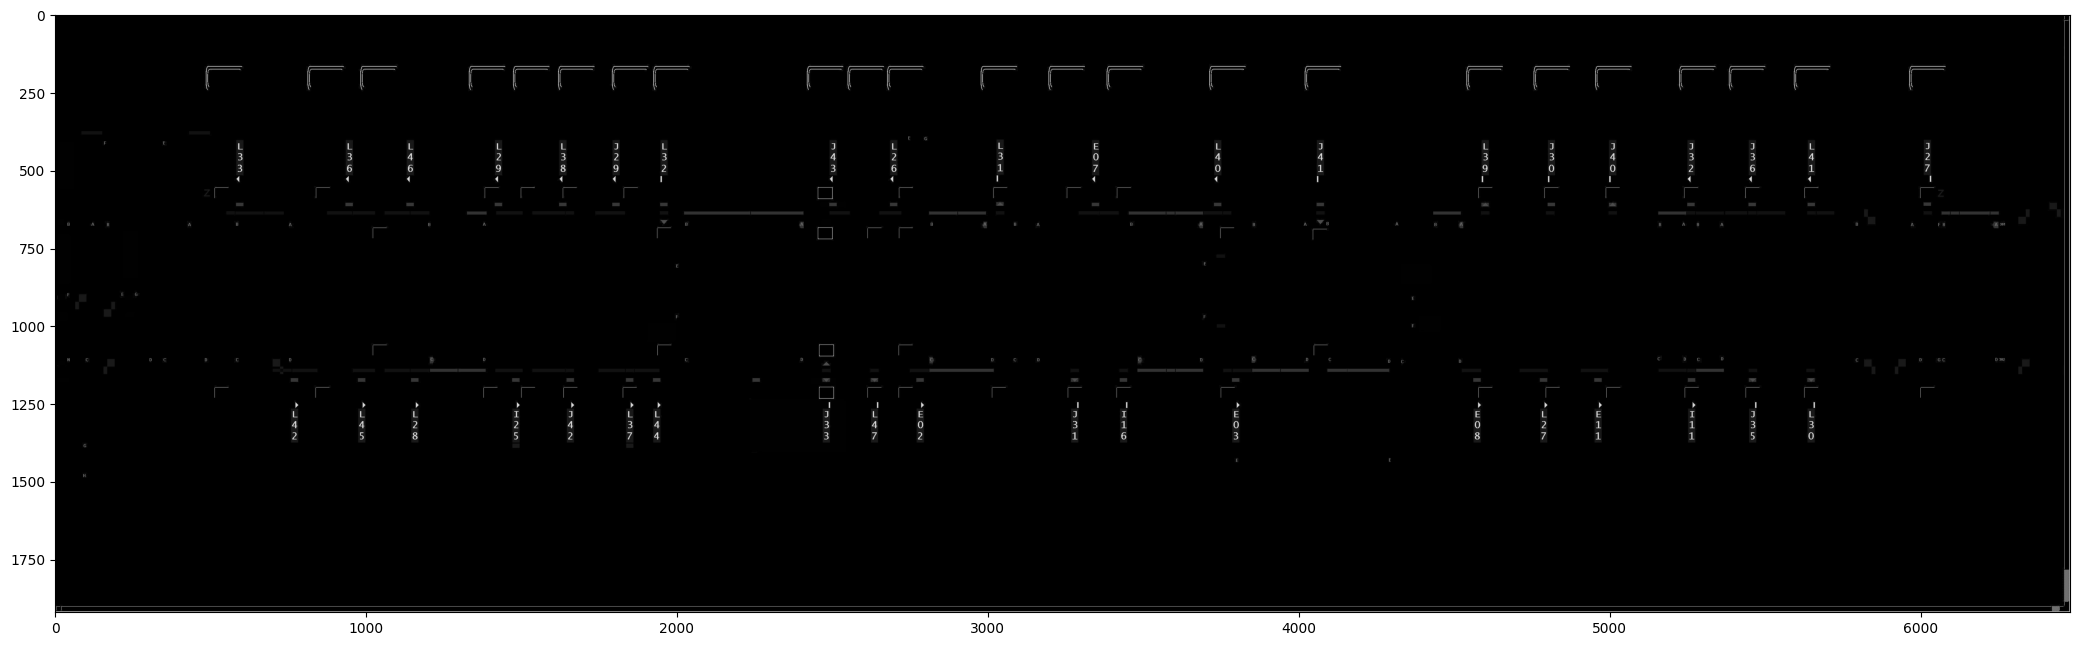

In [5]:
# Calculate the absolute difference between two images
# Image order is irrelevant since we will discard the sign
change = cv2.absdiff(gray, ref_gray)
# Set the size to show
plt.figure(figsize = (26,26))
# Show it!
plt.imshow(change, 'gray')

### Simple Thresholds in OpenCV

In [6]:
modes = ['cv2.THRESH_BINARY',
         'cv2.THRESH_BINARY_INV',
         'cv2.THRESH_TRUNC',
         'cv2.THRESH_TOZERO',
         'cv2.THRESH_TOZERO_INV']

# Basic threshold example
def my_threshold(thresh, modeStr):
    global change
    global dst
    mode = eval(modeStr)
    th, dst = cv2.threshold(change, thresh, 255, mode)
    fig, axes = plt.subplots(2, 1, figsize=(40, 20), sharex=True, sharey=True)
    ax = axes.ravel()
    ax[0].imshow(change,'gray')
    ax[1].imshow(dst,'gray')

# Pass function & its parameters to interactive
interactive(my_threshold, thresh = (0, 255), modeStr=modes)

# If your using Google Colab, comment the line above and use this here...
# my_threshold(25, 'cv2.THRESH_BINARY')

interactive(children=(IntSlider(value=127, description='thresh', max=255), Dropdown(description='modeStr', opt…

### Extract the original Pixels of what you've found: Image Multiplication

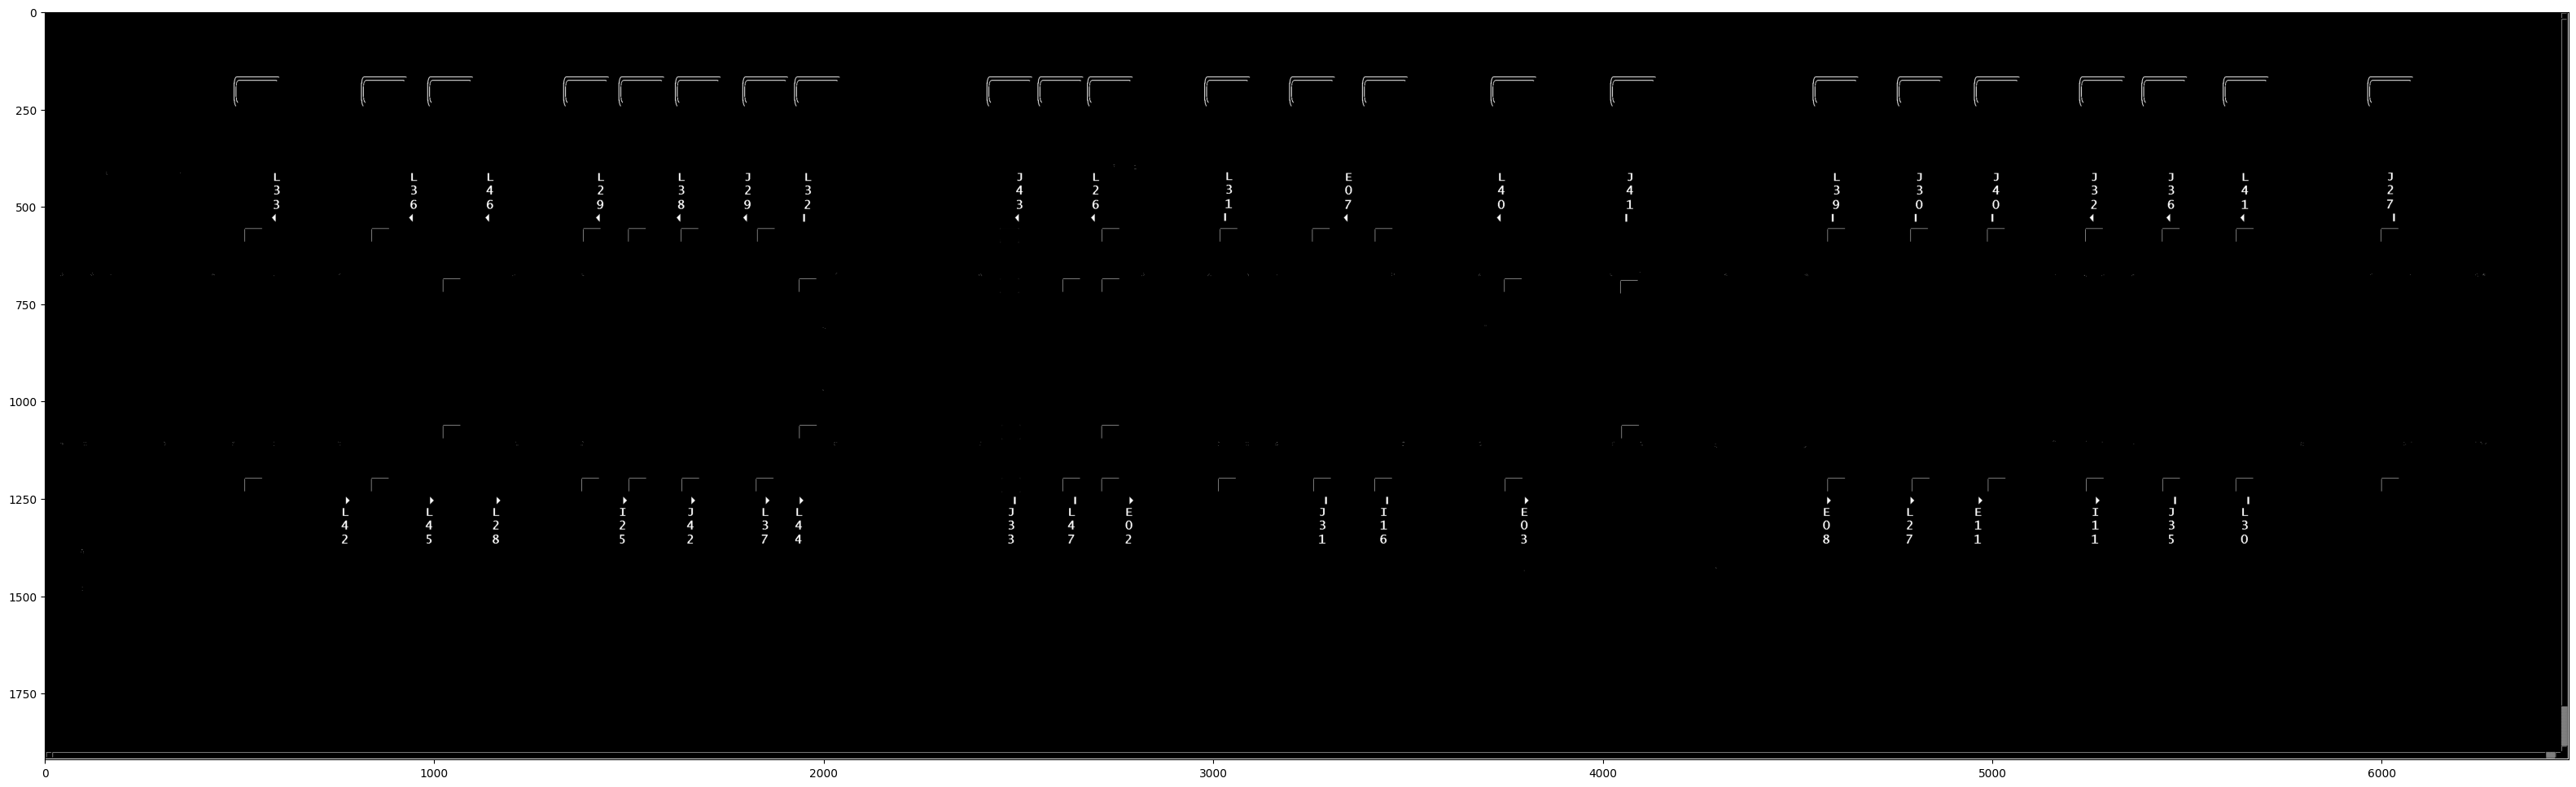

In [7]:
masked = cv2.multiply(gray, (dst//255))
# Set the size to show
plt.figure(figsize = (40,20))
# Show it!
plt.imshow(masked, 'gray')

### Discussão \#1:

Você ficou satisfeito com o resultado?

Você deve ter observado que você consegue obter dois tipos de resultados

* Se você eleva o seu limiar ao ponto de não incorporar ruído gerado pelas movimentações dos galhos da árvore no final e sujeira na rua, os seus carros vão aparecer cheios de buracos;

* Se você baixar o seu limiar de maneira que os veículos não fiquem cheios de buracos, a imagem vai ficar extremamente “suja” e também você vai ver interferência de postes porque uma  infinidade de pequenas alterações entre uma fotografia e outra vão ser capturadas pelo limiar.  Essas alterações são devidas à simples vibração do suporte da câmera e movimentação de sombras por causa da modificação da posição do Sol no céu.

O que você faria para resolver isto?


# 2.1.4. Refinando seu Exemplo com Operadores Morfológicos

Os ruídos que você viu no resultado da sequência de processamento de imagem anterior são devidos a falta de informação espacial dos operadores que nós usamos: 

buracos poderiam ser preenchidos simplesmente “sabendo-se” que ali existe um grande objeto coeso e aquele buraco na verdade é um erro de processamento;

pequenos ruídos poderiam ser eliminados simplesmente "sabendo-se” que um carro não pode ser um objeto pequeno e que qualquer objeto com uma área muito reduzida muito provavelmente vai ser simplesmente ruído na imagem;

Como resolver isto? Sequências de processamento em visão computacional clássica não possuem inteligência, então esse conhecimento acerca de buracos e de ruídos tem que ser introduzido de forma pré-definida por meio de métodos de processamento capazes de identificar esses problemas.

Como a informação que você precisa para identificar buracos e ruídos é apenas informação espacial simples, os Operadores Morfológicos são a solução mais indicada para resolver este problema.

* https://docs.opencv.org/3.0-beta/doc/py_tutorials/py_imgproc/py_morphological_ops/py_morphological_ops.html

### Dilation and Erosion, Opening and Closing

First you'll need a *kernel*. A simple kernel can be a square:

In [8]:
kernel = np.ones((5,5),np.uint8)
kernel

array([[1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1]], dtype=uint8)

You can also use more advanced kernel functions from OpenCV:

In [9]:
kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(5,9))
kernel

array([[0, 0, 1, 0, 0],
       [0, 1, 1, 1, 0],
       [1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1],
       [0, 1, 1, 1, 0],
       [0, 0, 1, 0, 0]], dtype=uint8)

We'll go directly to the composite operations **Opening and Closing**. Later, in the lecture about *Morphology* we will talk about **Eroding and Dilating**:

### *Open* the Mask with your Kernel

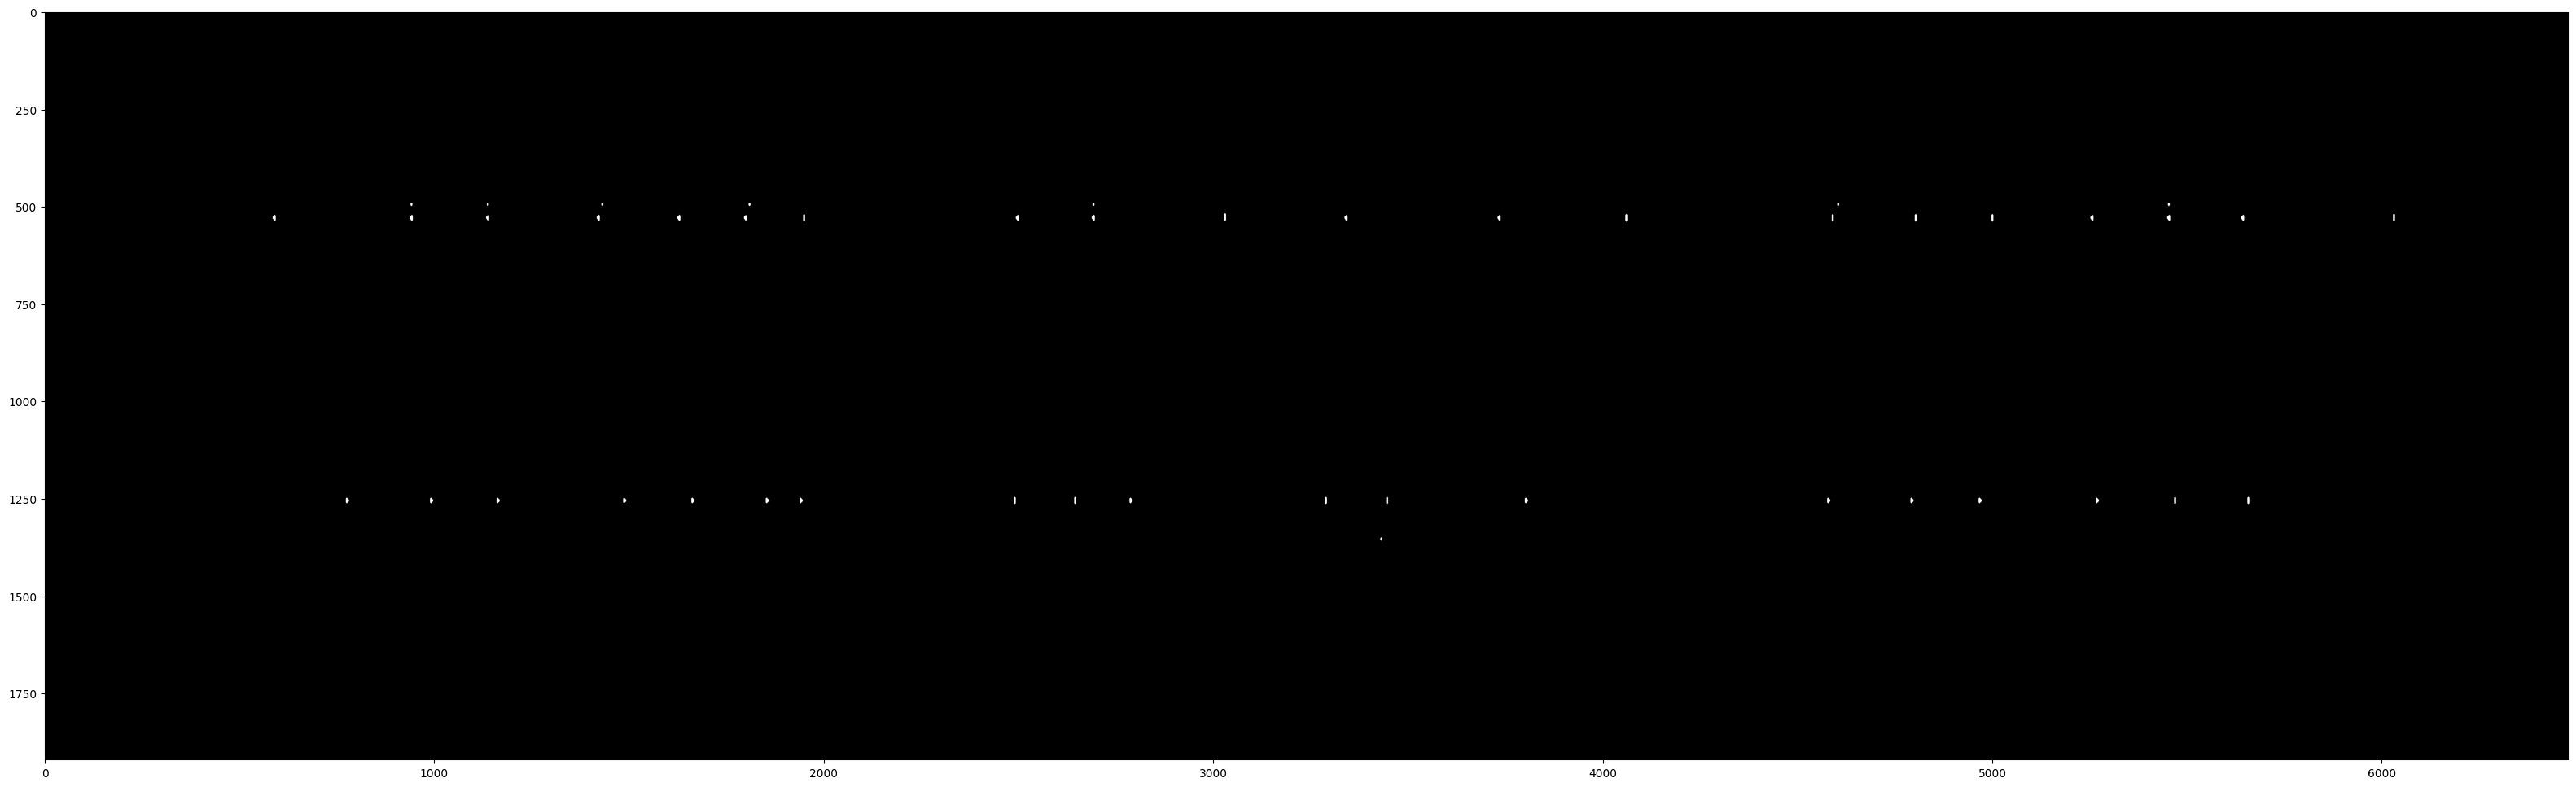

In [10]:
opening = cv2.morphologyEx(dst, cv2.MORPH_OPEN, kernel)
# Set the size to show
plt.figure(figsize = (40,20))
# Show it!
plt.imshow(opening, 'gray')

### *Close* the openend Mask with your Kernel

In [11]:
def myKernel(size):
    global kernel2
    kernel2 = np.ones((size,size),np.uint8)
    print(kernel2)

interactive(myKernel, size=(5,55,2))

interactive(children=(IntSlider(value=29, description='size', max=55, min=5, step=2), Output()), _dom_classes=…

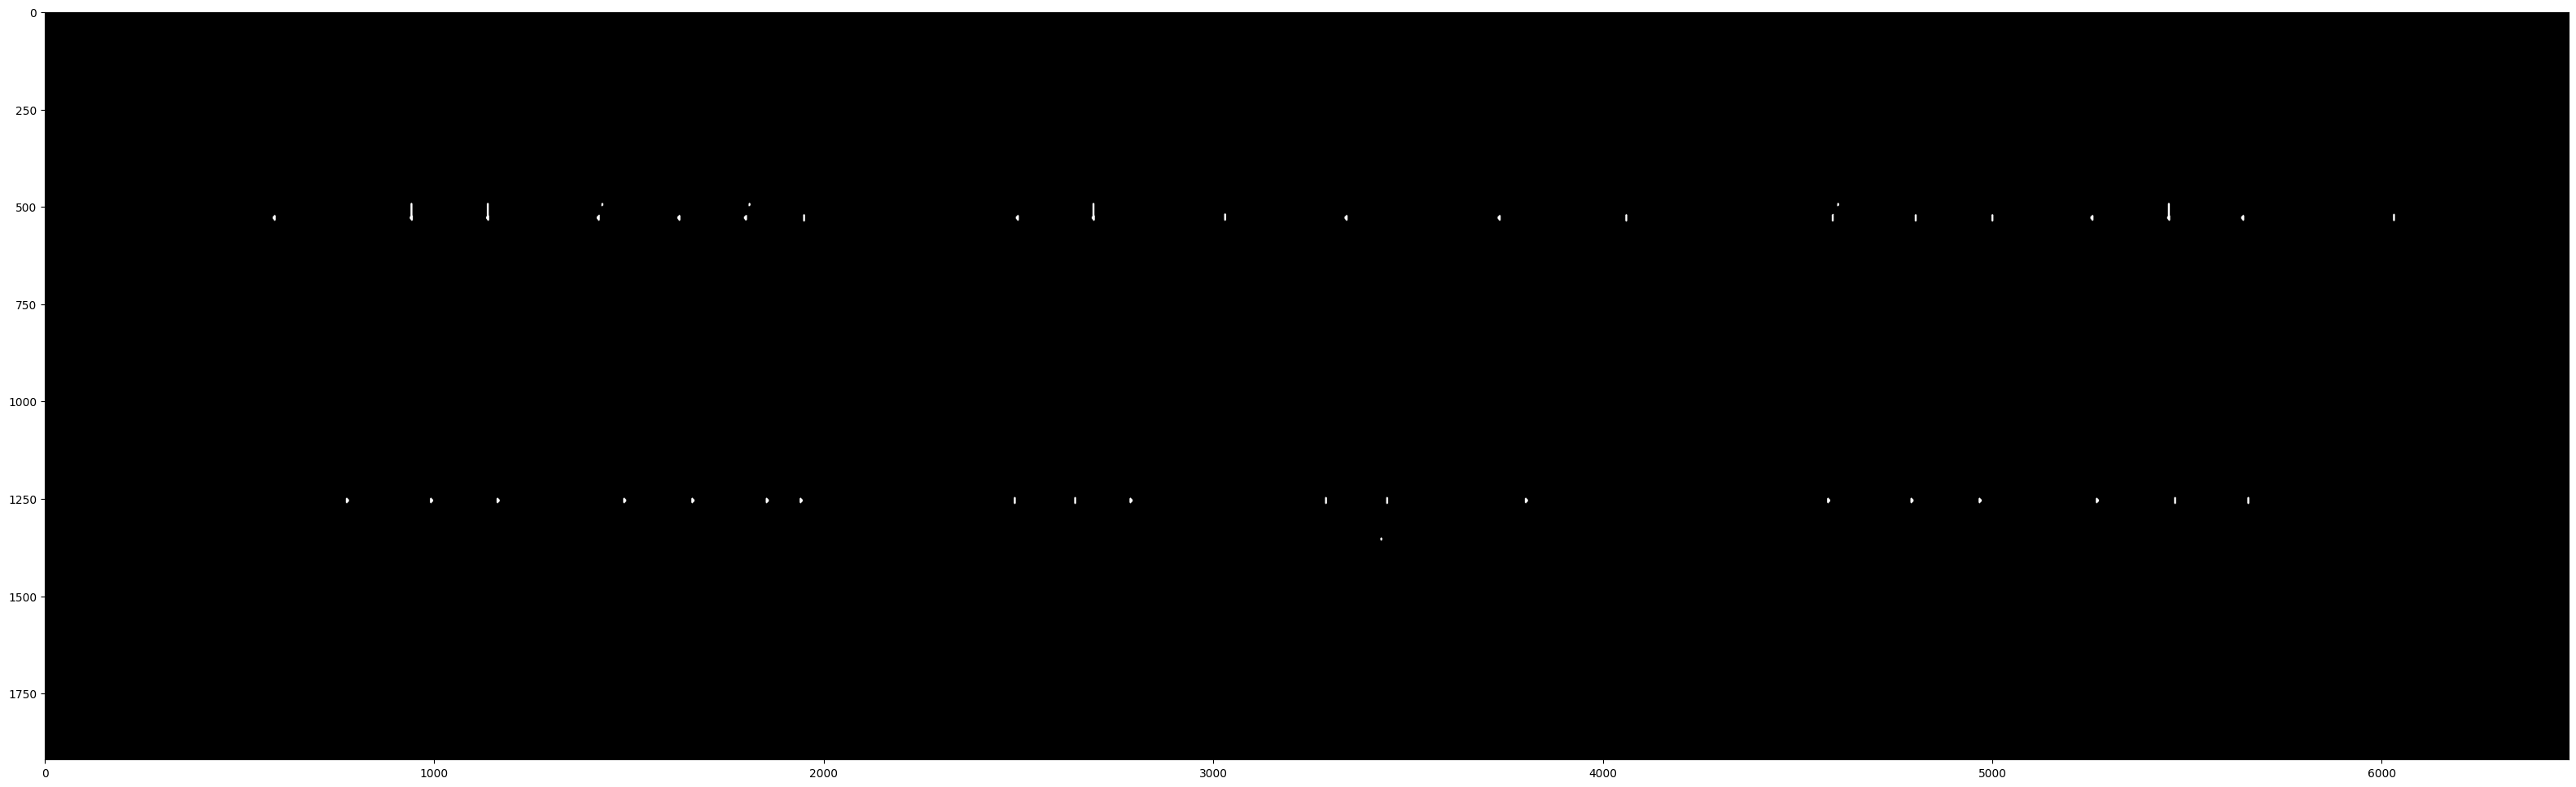

In [12]:
closing = cv2.morphologyEx(opening, cv2.MORPH_CLOSE, kernel2)
# Set the size to show
plt.figure(figsize = (40,20))
# Show it!
plt.imshow(closing, 'gray')

### Apply it again to your image

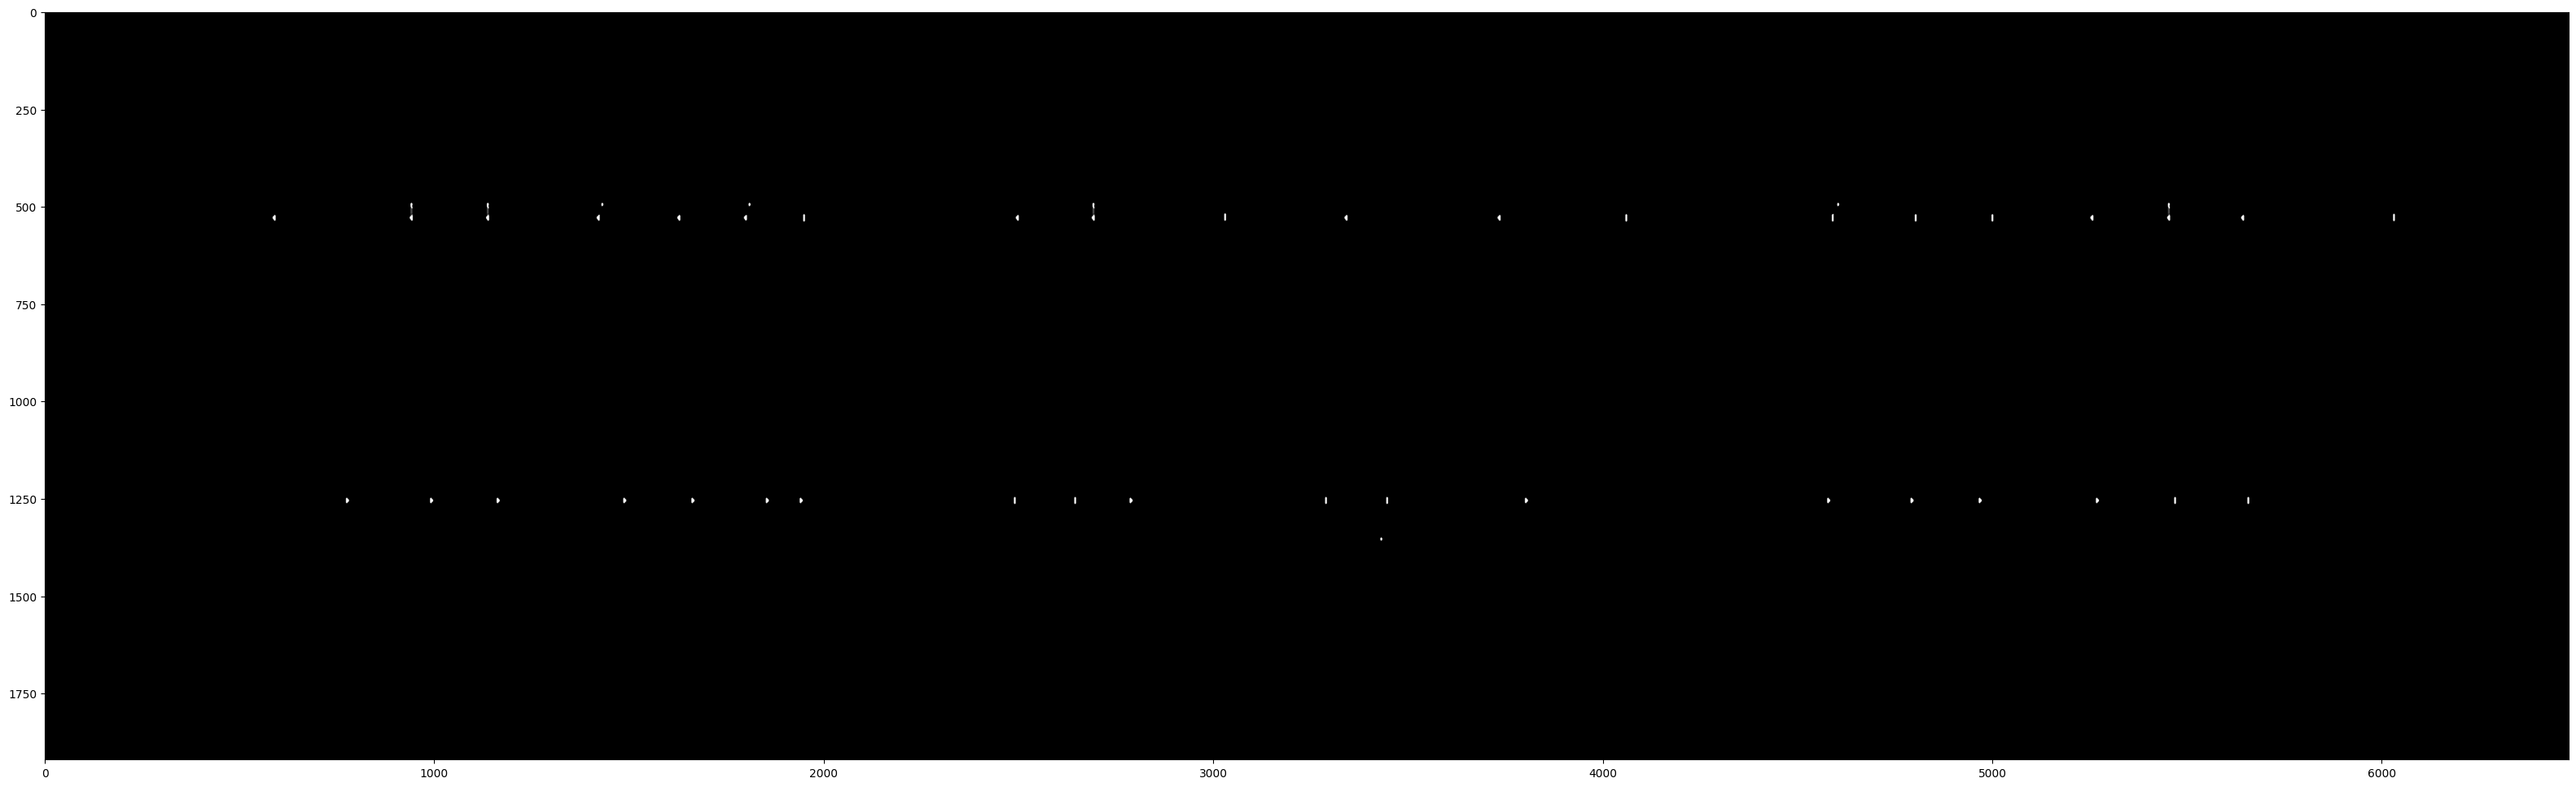

In [13]:
masked_with_morpho = cv2.multiply(gray, (closing//255))
# Set the size to show
plt.figure(figsize = (40,20))
# Show it!
plt.imshow(masked_with_morpho, 'gray')

### Discussão #2:

Agora você ficou satisfeito com o seu resultado?

Você acabou criando um operador morfológico customizado para eliminar chuvisco e outro operador morfológico customizado para fechar buracos. Você acredita que essa é uma solução generalizável e que pode ser aplicada a qualquer tipo de câmara de vigilância em semáforos?

# 2.1.5. Simple Examples of Value-Domain Functions

Adiante vão alguns exemplos adicionais de operadores e funções, em especial no Domínio do Valor. Execute-os como uma atividade suplementar em casa.

### OpenCV Initializations for the following Cells

In [14]:
# If you don't have already loaded these libs in the examples above, do it now
import cv2
import matplotlib
import numpy as np
from matplotlib import pyplot as plt

# Import interaction widgets and functions in order to be able to use sliders and menus
from ipywidgets import interact, interactive, interact_manual

### Image Mathematics

* Tutorial: Element-Wise Matrix Operations in OpenCV https://kdr2.com/tech/main/1810-elewise-matrix-op-opencv.html

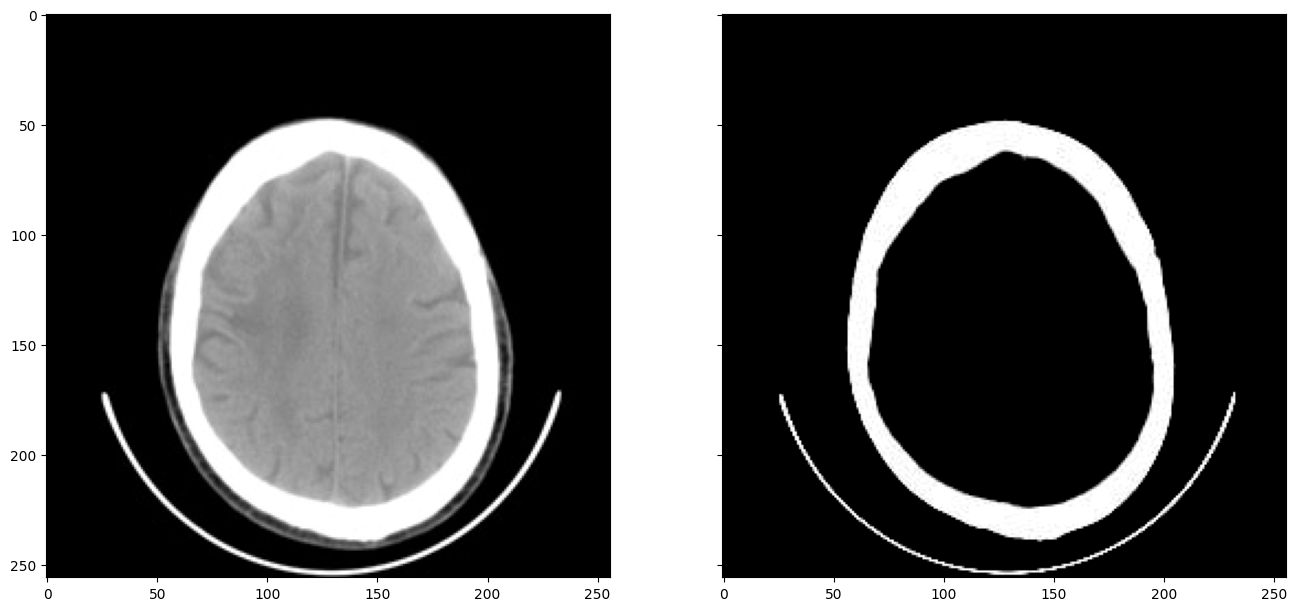

In [15]:
#!pip install -U scikit-image
# Load an image of a badly scanned text page
from skimage import data
image = data.page()

# Read a CT image
image = cv2.imread("../data/ct-01.jpg", cv2.IMREAD_GRAYSCALE)


#result = image + 40;
#result = cv2.multiply(image, 1.8)
result = cv2.subtract(image, 200)
#result = cv2.add(image, 200)

fig, axes = plt.subplots(1, 2, figsize=(16, 12), sharex=True, sharey=True)
ax = axes.ravel()
ax[0].imshow(image,'gray')
ax[1].imshow(result,'gray')


### Simple Thresholds in OpenCV

Material for reading:
* https://learnopencv.com/opencv-threshold-python-cpp/
* https://pyimagesearch.com/2021/04/28/opencv-thresholding-cv2-threshold/
* https://docs.opencv.org/4.x/d7/d4d/tutorial_py_thresholding.html

In [66]:
# Set the figure size, remembering that matplotlib
# uses INCHES and not pixels...
matplotlib.rcParams['figure.figsize'] = [8,8]

# Define a menu
modes = ['cv2.THRESH_BINARY',
         'cv2.THRESH_BINARY_INV',
         'cv2.THRESH_TRUNC',
         'cv2.THRESH_TOZERO',
         'cv2.THRESH_TOZERO_INV']

# Read image
src = cv2.imread("../data/ct-01.jpg", cv2.IMREAD_GRAYSCALE)

def myThresh(thresh, modeStr):
    global src
    mode = eval(modeStr)
    # Basic threhold example
    th, dst = cv2.threshold(src, thresh, 255, mode);
    fig, axes = plt.subplots(1, 2, figsize=(16, 12), sharex=True, sharey=True)
    ax = axes.ravel()
    ax[0].imshow(src,'gray')
    ax[1].imshow(dst,'gray')

# Pass function & its parameters to interactive
interactive(myThresh, thresh=(0,255,5), modeStr=modes)

interactive(children=(IntSlider(value=125, description='thresh', max=255, step=5), Dropdown(description='modeS…

### Adaptive Thresholds in OpenCV

In [67]:
# Define a few menus
modes = ['cv2.THRESH_BINARY',
         'cv2.THRESH_BINARY_INV',
         'cv2.THRESH_TRUNC',
         'cv2.THRESH_TOZERO',
         'cv2.THRESH_TOZERO_INV']

adaptModes = ['cv2.ADAPTIVE_THRESH_MEAN_C',
              'cv2.ADAPTIVE_THRESH_GAUSSIAN_C']

# Set the figure size, remembering that matplotlib
# uses INCHES and not pixels...
matplotlib.rcParams['figure.figsize'] = [8,8]

# Read image
src = cv2.imread("../data/ct-01.jpg", cv2.IMREAD_GRAYSCALE)

# Basic threshold example
def my_adaptThreshold(adaptModeStr, modeStr, neighborhood):
    global src
    mode = eval(modeStr)
    adaptMode = eval(adaptModeStr)
    dst = cv2.adaptiveThreshold(src, 255, adaptMode, mode, neighborhood, 10)
    fig, axes = plt.subplots(1, 2, figsize=(16, 12), sharex=True, sharey=True)
    ax = axes.ravel()
    ax[0].imshow(src,'gray')
    ax[1].imshow(dst,'gray')

# Pass function & its parameters to interactive
interactive(my_adaptThreshold, adaptModeStr=adaptModes, modeStr=modes, neighborhood=(3,31,2))



interactive(children=(Dropdown(description='adaptModeStr', options=('cv2.ADAPTIVE_THRESH_MEAN_C', 'cv2.ADAPTIV…

### Adaptive Thresholds in SciKit

SciKit only can do mean-based adaptive thresholding.

What is SciPy and what are SciKits in Python?
 * [SciPy is a Python-based ecosystem of open-source software for mathematics, science, and engineering](https://www.scipy.org/)
 * [SciPy Toolkits are add-on packages for SciPy](https://www.scipy.org/scikits.html)
   * [scikit-image is a collection of algorithms for image processing](https://scikit-image.org/)
   * [scikit-learn are sSimple and efficient tools for data mining and data analysis](https://scikit-learn.org/stable/)

In [68]:
import cv2
import matplotlib.pyplot as plt
from skimage import data
from skimage.filters import threshold_otsu, threshold_local
# Import interaction widgets and functions
from ipywidgets import interact, interactive, interact_manual

image = data.page()
# Read image
# image = cv2.imread("../data/ct-01.jpg", cv2.IMREAD_GRAYSCALE)



block_size = 35

# Basic threshold example
def my_scikitAdaptThreshold(neighborhood):
    global image

    global_thresh = threshold_otsu(image)
    binary_global = image > global_thresh

    binary_adaptive = threshold_local(image, neighborhood, offset=10)

    fig, axes = plt.subplots(ncols=3, figsize=(20, 8))
    ax0, ax1, ax2 = axes
    plt.gray()

    ax0.imshow(image)
    ax0.set_title('Image')

    ax1.imshow(binary_global)
    ax1.set_title('Global thresholding')

    ax2.imshow(binary_adaptive)
    ax2.set_title('Adaptive thresholding')

    for ax in axes:
        ax.axis('off')

    plt.show()

# Pass function & its parameters to interactive
interactive(my_scikitAdaptThreshold, neighborhood=(3,31,2))

interactive(children=(IntSlider(value=17, description='neighborhood', max=31, min=3, step=2), Output()), _dom_…

## Histogram Thresholds

### Histogram Thresholds in SciKit #1: Bimodal based upon the Global Minimum

For pictures with a bimodal histogram, more specific algorithms can be used.
For instance, the minimum algorithm takes a histogram of the image and smooths it
repeatedly until there are only two peaks in the histogram.


In [69]:
import cv2
import matplotlib.pyplot as plt
from skimage import data
from skimage.filters import threshold_minimum
# Import interaction widgets and functions
from ipywidgets import interact, interactive, interact_manual


#image = data.camera()
image = cv2.imread("../data/ct-01.jpg", cv2.IMREAD_GRAYSCALE)

def my_histo_threshold(bins):
    global image

    thresh_min = threshold_minimum(image, bins)
    binary_min = image > thresh_min

    fig, ax = plt.subplots(2, 2, figsize=(10, 10))

    ax[0, 0].imshow(image, cmap=plt.cm.gray)
    ax[0, 0].set_title('Original')

    ax[0, 1].hist(image.ravel(), bins=bins)
    ax[0, 1].set_title('Histogram')

    ax[1, 0].imshow(binary_min, cmap=plt.cm.gray)
    ax[1, 0].set_title('Thresholded (min)')

    ax[1, 1].hist(image.ravel(), bins=bins)
    ax[1, 1].axvline(thresh_min, color='r')

    for a in ax[:, 0]:
        a.axis('off')
    plt.show()

# Pass function & its parameters to interactive
interact_manual(my_histo_threshold, bins=(2, 256))

interactive(children=(IntSlider(value=129, description='bins', max=256, min=2), Button(description='Run Intera…

<function __main__.my_histo_threshold(bins)>

### Histogram Thresholds in SciKit #2: Bimodal based upon the Otsu's and a Collection of other Methods

Otsu's method [1] calculates an "optimal" threshold (marked by a red line in the histogram below) performing a Cluster Analysis that maximizes the variance between two classes of pixels, which are separated by the threshold. Equivalently, clustering method minimizes the intra-class variance.

* [1] http://en.wikipedia.org/wiki/Otsu's_method
* https://learnopencv.com/otsu-thresholding-with-opencv/

In [70]:
import cv2
import matplotlib.pyplot as plt
from skimage import data
from skimage.filters import threshold_otsu, threshold_yen, threshold_isodata, threshold_li, threshold_triangle
# Import interaction widgets and functions
from ipywidgets import interact, interactive, interact_manual

methods = [
    'threshold_otsu(image, bins)',
    'threshold_yen(image, bins)',
    'threshold_isodata(image, bins)',
    'threshold_li(image)',
    'threshold_triangle(image, bins)']

image = data.camera()
# Read image
# image = cv2.imread("../data/ct-01.jpg", cv2.IMREAD_GRAYSCALE)

def my_potpourri(method, bins):
    global image

    # Eval it!
    thresh = eval(method)
    # Generate a binary image
    binary = image > thresh

    fig, axes = plt.subplots(ncols=3, figsize=(20, 5))
    ax = axes.ravel()
    ax[0] = plt.subplot(1, 3, 1)
    ax[1] = plt.subplot(1, 3, 2)
    ax[2] = plt.subplot(1, 3, 3, sharex=ax[0], sharey=ax[0])

    ax[0].imshow(image, cmap=plt.cm.gray)
    ax[0].set_title('Original')
    ax[0].axis('off')

    ax[1].hist(image.ravel(), bins=bins)
    ax[1].set_title('Histogram '+str(bins))
    ax[1].axvline(thresh, color='r')

    ax[2].imshow(binary, cmap=plt.cm.gray)
    ax[2].set_title('Thresholded: '+ method)
    ax[2].axis('off')

    plt.show()

# Pass function & its parameters to interactive
interact_manual(my_potpourri, method=methods, bins=(2, 256))

interactive(children=(Dropdown(description='method', options=('threshold_otsu(image, bins)', 'threshold_yen(im…

<function __main__.my_potpourri(method, bins)>

# Credits

* The OpenCV grayscale threshold examples were adapted from the following material:
  * https://www.learnopencv.com/opencv-threshold-python-cpp/
  * https://docs.opencv.org/3.4.0/d7/d4d/tutorial_py_thresholding.html
* The SciKit grayscale threshold examples were adapted from the following materail:
  * https://scikit-image.org/docs/0.12.x/auto_examples/segmentation/plot_threshold_adaptive.html
  * https://scikit-image.org/docs/0.14.x/auto_examples/xx_applications/plot_thresholding.html

![banner cnns ppgcc ufsc](https://lapix.ufsc.br/wp-content/uploads/2022/10/rodape-CC.png)